Loading the Fashion-MNIST data.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

Converting the images to floating point data and rescaling them between 0 and 1. Creating one-hot vectors from the labels.

In [2]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

Creating 2D UMAP and PCA embeddings for visualizing the data.

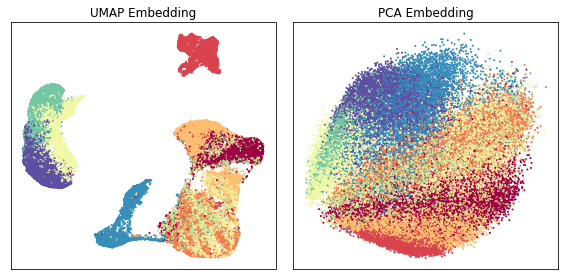

In [3]:
import os
import pickle
from umap import UMAP
from sklearn.decomposition import PCA


def create_embeddings(data, ignore_cache=False):
    umap_dir = "cache/umap.pickle"
    pca_dir = "cache/pca.pickle"

    if not os.path.isfile(umap_dir) or ignore_cache:
        umap_reducer = UMAP(random_state=42).fit(data)
        pickle.dump(umap_reducer, open(umap_dir, "wb"))
    else:
        umap_reducer = pickle.load(open(umap_dir, "rb"))

    if not os.path.isfile(pca_dir) or ignore_cache:
        pca_reducer = PCA(n_components=2, random_state=42).fit(data)
        pickle.dump(pca_reducer, open(pca_dir, "wb"))
    else:
        pca_reducer = pickle.load(open(pca_dir, "rb"))
        
    return umap_reducer, pca_reducer


umap_reducer, pca_reducer = create_embeddings(train_x.reshape(-1, 784), ignore_cache=False)
umap_data = umap_reducer.transform(train_x.reshape(-1, 784))
pca_data = pca_reducer.transform(train_x.reshape(-1, 784))


def plot_embeddings():
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
    axes[0].scatter(umap_data[:,0], umap_data[:,1], s=1, c=train_labels, cmap='Spectral')
    axes[0].set_title("UMAP Embedding")

    axes[1].scatter(pca_data[:,0], pca_data[:,1], s=1, c=train_labels, cmap='Spectral')
    axes[1].set_title("PCA Embedding")
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()
    
plot_embeddings()

Helper function for plotting the movement of clusters during training.

In [4]:
def plot_cluster_movement(ax, data, init, current):
    change = current - init
    
    ax.scatter(data[:,0], data[:,1], s=1, c=train_labels, cmap='Spectral')
    s1 = ax.scatter(init[:,0], init[:,1], s=100, c="k", marker="^")
    s2 = ax.scatter(current[:,0], current[:,1], s=100, c="r", marker="^")
    
    for i in range(change.shape[0]):
        ax.arrow(init[i,0], init[i,1], change[i,0], change[i,1])
    ax.legend([s1, s2], ["Before Training", "After Training"])

Training the model with a random initialization. Plot the cluster movement over the course of training. Plot the training and test accuracy over the course of training.

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.3115 - categorical_accuracy: 0.5493 - val_loss: 0.2292 - val_categorical_accuracy: 0.7434
Epoch 2/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1965 - categorical_accuracy: 0.7727 - val_loss: 0.1718 - val_categorical_accuracy: 0.7741
Epoch 3/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.1525 - categorical_accuracy: 0.8008 - val_loss: 0.1392 - val_categorical_accuracy: 0.8032
Epoch 4/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1267 - categorical_accuracy: 0.8188 - val_loss: 0.1208 - val_categorical_accuracy: 0.8129
Epoch 5/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1101 - categorical_accuracy: 0.8313 - val_loss: 0.1094 - val_categorical_accuracy: 0.8187
Epoch 6/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.0994 - categor

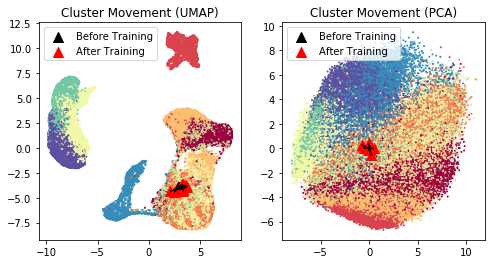

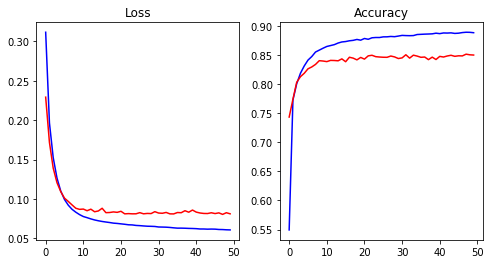

In [10]:
import keras
import keras.layers as layers
import keras.models as models
from model import GaussMembership, normalized_product_fn


def train_random_initialization():
    # create the model
    model = keras.Sequential([
        layers.Reshape((784,), input_shape=(28,28)),
        GaussMembership(10),
        layers.Lambda(lambda x: normalized_product_fn(x)),
        layers.Dense(10, activation="sigmoid"),])
    
    # set weights randomly
    model.layers[1].set_weights((
        # multiplying the by the mean is a way to ensure that the centers occupy the same subset of the
        # feature space as the input data
        np.random.normal(1., 0.1, size=(10,784)) * np.mean(train_x.reshape(-1, 784), axis=0, keepdims=True),
        np.random.normal(1., 0.1, size=(10,784))))
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])
    
    init_mu = model.layers[1].get_weights()[0]

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=50,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    final_mu = model.layers[1].get_weights()[0]
    
    # plot the cluster movement
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
    axes[0].set_title("Cluster Movement (UMAP)")
    plot_cluster_movement(
        axes[0], umap_data,
        umap_reducer.transform(init_mu), 
        umap_reducer.transform(final_mu))

    axes[1].set_title("Cluster Movement (PCA)")
    plot_cluster_movement(
        axes[1], pca_data,
        pca_reducer.transform(init_mu), 
        pca_reducer.transform(final_mu))
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    #axes[1].set_ylim((0.8, 1))
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")
    
train_random_initialization()

The clusters still do not appear to fit the data in the projections. This has happened in all experiments despite the network being able to fit the data quite well. It may just be an artifact of the high number of dimensions and the projections. This phenomena will need to be investigated more in-depth later.

Next, the model is trained using the FCM initialization.

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.4516 - categorical_accuracy: 0.3786 - val_loss: 0.3208 - val_categorical_accuracy: 0.4632
Epoch 2/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.2713 - categorical_accuracy: 0.5515 - val_loss: 0.2305 - val_categorical_accuracy: 0.6108
Epoch 3/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.2013 - categorical_accuracy: 0.6641 - val_loss: 0.1804 - val_categorical_accuracy: 0.6865
Epoch 4/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1626 - categorical_accuracy: 0.7297 - val_loss: 0.1499 - val_categorical_accuracy: 0.7506
Epoch 5/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1337 - categorical_accuracy: 0.7916 - val_loss: 0.1239 - val_categorical_accuracy: 0.8069
Epoch 6/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1120 - categor

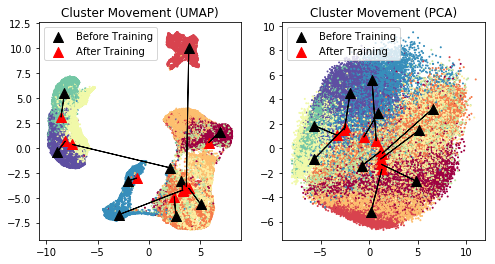

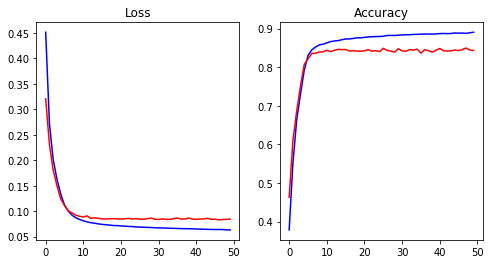

In [6]:
import skfuzzy as skf


def train_fcm_initialization():
    # create the model
    model = keras.Sequential([
        layers.Reshape((784,), input_shape=(28,28)),
        GaussMembership(10),
        layers.Lambda(lambda x: normalized_product_fn(x)),
        layers.Dense(10, activation="sigmoid"),])
    
    init_mu, memberships, u0, d, jm, p, fpc = skf.cmeans(
        train_x.reshape(-1, 784).T, 10, 1.1, 1e-8, 1000, seed=0)
    
    # set weights with fcm
    model.layers[1].set_weights((
        init_mu,
        np.random.normal(1., 0.1, size=(10,784))))
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=50,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    final_mu = model.layers[1].get_weights()[0]
    
    # plot the cluster movement
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
    axes[0].set_title("Cluster Movement (UMAP)")
    plot_cluster_movement(
        axes[0], umap_data,
        umap_reducer.transform(init_mu), 
        umap_reducer.transform(final_mu))

    axes[1].set_title("Cluster Movement (PCA)")
    plot_cluster_movement(
        axes[1], pca_data,
        pca_reducer.transform(init_mu), 
        pca_reducer.transform(final_mu))
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    #axes[1].set_ylim((0.8, 1))
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")
    
train_fcm_initialization()

When initialized using FCM, the clusters start in more appropriate locations but move towards the center of dataset. Even though the clusters appear to be in better locations, the performance slightly worse than the random initialization.